In [1]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch

from openretina.utils.nnfabrik_model_loading import load_ensemble_model_from_remote
from openretina.utils.plotting import plot_stimulus_composition, play_stimulus
from openretina.insilico.stimulus_optimization.optimizer import optimize_stimulus
from openretina.insilico.stimulus_optimization.objective import SingleNeuronObjective, MeanReducer, SliceMeanReducer
from openretina.insilico.stimulus_optimization.optimization_stopper import OptimizationStopper
from openretina.insilico.stimulus_optimization.regularizer import (
    ChangeNormJointlyClipRangeSeparately,
    RangeRegularizationLoss,
)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_info, ensemble_model = load_ensemble_model_from_remote()

Random seed 0 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 1000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 2000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 3000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default
Random seed 4000 has been set.
Ignored Missing keys:
core.features.layer1.conv._log_speed_default
core.features.layer0.conv._log_speed_default


In [3]:
stimulus_shape = (1, 2, 50, 18, 16)

STIMULUS_RANGE_CONSTRAINTS = {
    "norm": 30.0,
    "x_min_green": -0.654,
    "x_max_green": 6.269,
    "x_min_uv": -0.913,
    "x_max_uv": 6.269,
}
neuron_id = 42

# pick a random session and neuron
session_id = list(ensemble_model.members[0].readout.keys())[0]

In [4]:
response_reducer = SliceMeanReducer(axis=0, start=10, length=10)
objective = SingleNeuronObjective(
    ensemble_model, 
    neuron_idx=neuron_id, 
    data_key=session_id, 
    response_reducer=response_reducer
)
stimulus = torch.randn(stimulus_shape, requires_grad=True, device=device)
stimulus_postprocessor = ChangeNormJointlyClipRangeSeparately(
    min_max_values=[
        (STIMULUS_RANGE_CONSTRAINTS["x_min_green"], STIMULUS_RANGE_CONSTRAINTS["x_max_green"]),
        (STIMULUS_RANGE_CONSTRAINTS["x_min_uv"], STIMULUS_RANGE_CONSTRAINTS["x_max_uv"]),
    ],
    norm=STIMULUS_RANGE_CONSTRAINTS["x_max_uv"],
)
optimization_stopper = OptimizationStopper(max_iterations=10)
stimulus.data = stimulus_postprocessor.process(stimulus.data)
optimizer_init_fn = partial(torch.optim.SGD, lr=10.0)


In [5]:
optimize_stimulus(
    stimulus,
    optimizer_init_fn,
    objective,
    optimization_stopper,
    stimulus_postprocessor=None, # stimulus_postprocessor.process,
    stimulus_regularization_loss=None,
)
stimulus_np = stimulus[0].cpu().numpy()

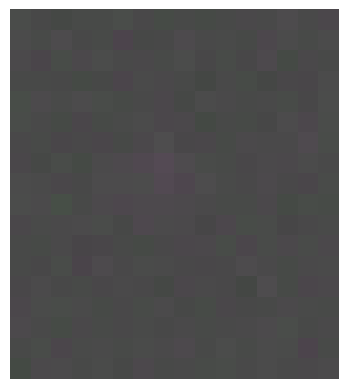

In [6]:
play_stimulus(stimulus[0])

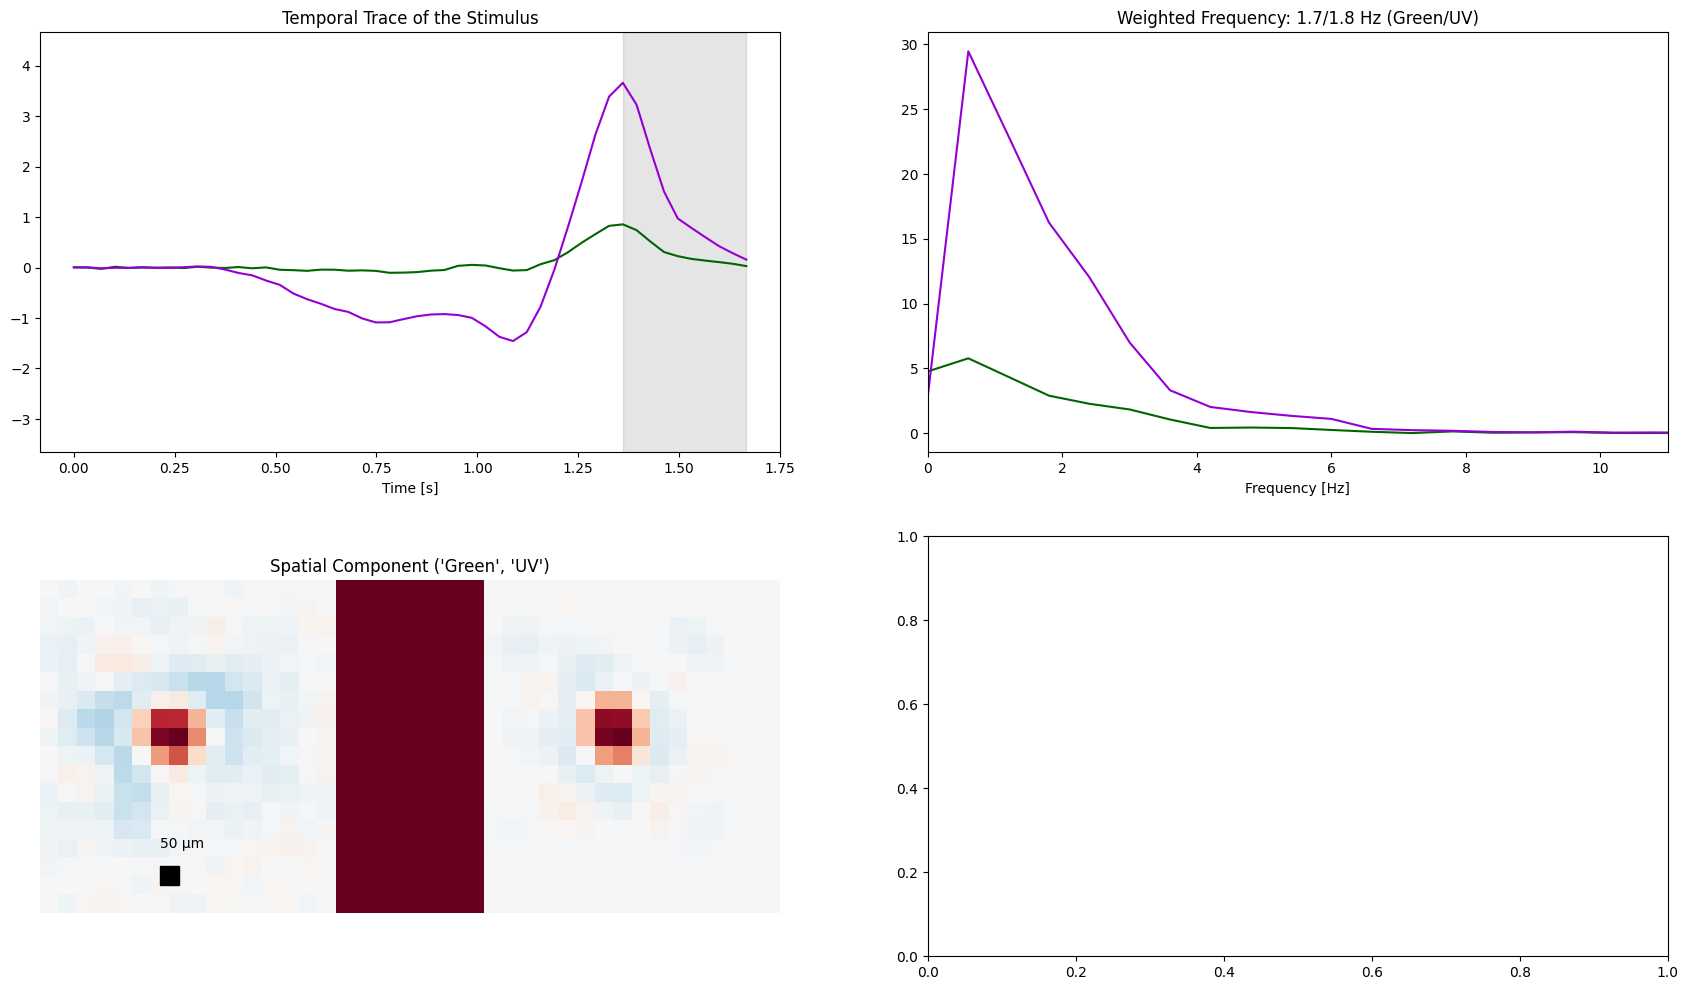

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(7 * 3, 12))
plot_stimulus_composition(
    stimulus=stimulus_np,
    temporal_trace_ax=axes[0, 0],
    freq_ax=axes[0, 1],
    spatial_ax=axes[1, 0],
    highlight_x_list=[(40, 49)],
)